In [44]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

In [8]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
import mysql.connector

db = mysql.connector.connect(
 host='localhost',
 user='root',
 passwd='iloveSCnb2018!',
 database='batchdata'
)

str_sql = '''
SELECT * from steam_transformed;
'''
df = pd.read_sql(sql=str_sql, con=db)
df.head(5)

In [12]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'recommendationid', 'author', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'weighted_vote_score', 'app_id', 'title', 'date_release', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'os',
       'time_between_comment_and_game', 'days_between_comment_and_game',
       'rating_numerical', 'rating_simplified'],
      dtype='object')

In [13]:
data.rating_numerical.value_counts()

rating_numerical
 0    109844
 2    109196
 3     94975
 1     74865
-1     16811
 4      7666
-2      2849
-3       882
-4        41
Name: count, dtype: int64

In [60]:
# positive edges: user with rating > 0, negative edges: user with rating < 0
df = data[data['rating_numerical']> 0].loc[:150000]
print(len(df))
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

130414
Rating Distribution


rating
Mostly Positive            24501
Overwhelmingly Positive     3829
Positive                   36974
Very Positive              65110
Name: rating, dtype: int64

In [61]:
# Split data into training and testing sets with a test size of 20% and a fixed random state for reproducibility
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  104331
Test Size :  26083


In [62]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'recommendationid', 'author', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'weighted_vote_score', 'app_id', 'title', 'date_release', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'os',
       'time_between_comment_and_game', 'days_between_comment_and_game',
       'rating_numerical', 'rating_simplified'],
      dtype='object')

In [63]:
# Use label encoding to transform user IDs and item IDs into integer indices for the training set
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['author'].values)
train['item_id_idx'] = le_item.fit_transform(train['app_id'].values)
train_user_ids = train['author'].unique()
train_item_ids = train['app_id'].unique()

print(len(train_user_ids), len(train_item_ids))

# Ensure that the test set only contains users and items that also appear in the training set
test = test[(test['author'].isin(train_user_ids)) & (test['app_id'].isin(train_item_ids))]
print(len(test))

80724 13803
7937


In [64]:
# Transform user IDs and item IDs in the test set using the label encoders fitted on the training set
test['user_id_idx'] = le_user.transform(test['author'].values)
test['item_id_idx'] = le_item.transform(test['app_id'].values)
# Calculate the number of unique users and items in the training set
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  80724
Number of unique Items :  13803


In [65]:
import csv
mapping_user = dict(zip(le_user.classes_, range(len(le_user.classes_))))
mapping_game = dict(zip(le_item.classes_, range(len(le_item.classes_))))
with open('user_mapping.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in mapping_user.items():
       writer.writerow([key, value])

with open('game_mapping.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in mapping_game.items():
       writer.writerow([key, value])

# data fetched, encoded values

In [66]:
# Set model hyperparameters: latent dimension and number of layers
latent_dim = 64  # Dimensionality of the latent feature space
n_layers = 3  # Number of layers in the neural network

import torch

# Define a function to convert a DOK matrix to a sparse tensor in PyTorch
def convert_to_sparse_tensor(dok_mtrx):
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)  # Convert DOK matrix to COO format and ensure data type
    values = dok_mtrx_coo.data  # Extract non-zero values
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [75]:
# Function to compute evaluation metrics for a recommendation system model
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    # Initialize user and item embeddings using pre-trained weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    # Get unique user IDs in the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # Initialize a sparse matrix R with interactions from the training data
    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    # Convert sparse matrix R to a sparse tensor
    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    # Add the relevance score matrix and the non-interacted items matrix
    relevance_score = relevance_score + R_tensor_dense

    # Retrieve the top-K relevance scores and their corresponding indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # pickle.dump(relevance_score, open(f"model_stats/relevance_score.pkl", "wb"))
    
    # Group the test set by user ID and retrieve the list of interacted items
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    # Check if each recommended item is in the interacted item list
    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]
    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
    def get_cumsum(hit_list):
        return np.cumsum(hit_list)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)
    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

In [68]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        # Create adjacency matrix for the user-item graph
        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        # Normalize the adjacency matrix
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    # propagate user and item embeddings through the network for a specified number of layers
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    # define the forward pass of the model, compute the final embeddings for given users and items
    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [69]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([94527, 64])


In [70]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    # Compute regularization loss
    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))

    # Compute scores for positive and negative items
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # Compute BPR loss using softplus function
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

In [71]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    # Randomly select users for batch training
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    # Select positive and negative items for each user
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [72]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.01)
EPOCHS = 50
BATCH_SIZE = 256
DECAY = 0.001
K = 15

In [73]:
import os
from os.path import isfile, join

In [1]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []


for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

    # if epoch % 10 == 0:

    #   # save embeddings for future visualization
    #   path = os.path.join("model_embeddings", lightGCN.name)
    #   if not os.path.exists(path):
    #     os.makedirs(path)
    #   torch.save(lightGCN.embedding.weight, os.path.join("model_embeddings",  f"lightGCN_{epoch}.pt"))

stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'ndcg': [],
        'precision': [],
        'map': [],
        'roc' : []
      }

  }




In [77]:
pickle.dump(stats, open("lightGCN__model_stats.pkl", "wb"))

In [82]:
final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()

In [89]:
# Initialize user and item embeddings using pre-trained weights
user_Embedding = nn.Embedding(final_user_Embed.size()[0], final_user_Embed.size()[1], _weight = final_user_Embed)
item_Embedding = nn.Embedding(final_item_Embed.size()[0], final_item_Embed.size()[1], _weight = final_item_Embed)

    # Compute relevance score matrix based on user and item embeddings
relevance_score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))

    # Initialize a sparse matrix R with interactions from the training data
R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
R[train['user_id_idx'], train['item_id_idx']] = 1.0

    # Convert sparse matrix R to a sparse tensor
R_tensor = convert_to_sparse_tensor(R)
R_tensor_dense = R_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
R_tensor_dense = R_tensor_dense*(-np.inf)
R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    # Add the relevance score matrix and the non-interacted items matrix
relevance_score = relevance_score + R_tensor_dense
#relevance_score: shape 80724 (users) * 13803 (games)


In [95]:
pickle.dump(relevance_score, open("LightGCN_result.pkl", "wb"))
pickle.dump(final_user_Embed, open("LightGCN_user_embedding.pkl", "wb"))
pickle.dump(final_user_Embed, open("LightGCN_item_embedding.pkl", "wb"))

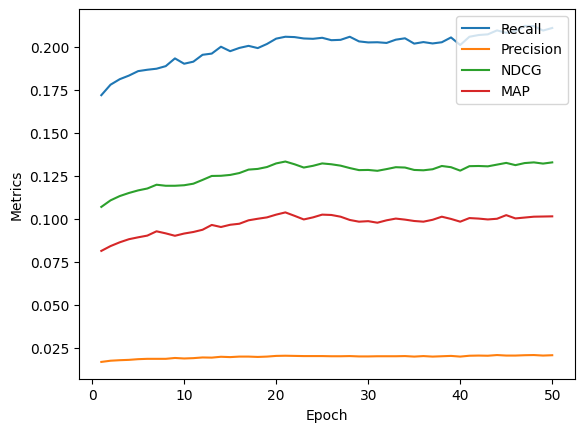

In [78]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

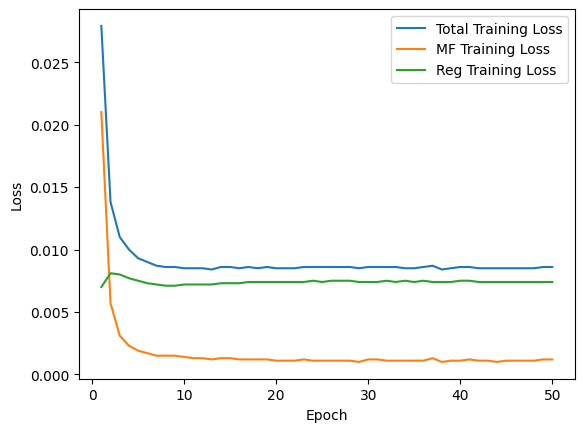

In [79]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [80]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.211
Last Epoch's Test Data Precision ->  0.0206
Last Epoch's Test Data NDCG ->  0.1328
Last Epoch's Test Data MAP ->  0.1014
Last Epoch's Train Data Loss ->  0.0086


what do to with the result: with the LightGCN_result.pkl file, we are able to retrieve the relevance score of users with games: for each user in the streaming data, we will be looking up the relevance score and output the games that have the highest K (e.g. 10) scores. To retrieve the names of the games, we need to use the game_mapping.csv, where the index of game in the scoring matrix corresponds to the app id. 